In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import uuid

In [2]:
np.random.seed(42)
dates = pd.date_range(start='2025-01-01', end='2025-01-07', freq='h')
vehicle_counts = np.random.normal(loc=200, scale=50, size=len(dates)).astype(int)
vehicle_counts = np.clip(vehicle_counts + np.sin(np.arange(len(dates)) * 2 * np.pi / 24) * 100, 50, 400).astype(int)
anomaly_indices = np.random.choice(len(dates), size=5, replace=False)
vehicle_counts[anomaly_indices] *= 2
data = pd.DataFrame({'timestamp': dates, 'vehicle_count': vehicle_counts})

In [3]:
data.to_csv('traffic_data.csv', index=False)

In [4]:
df = pd.read_csv('traffic_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

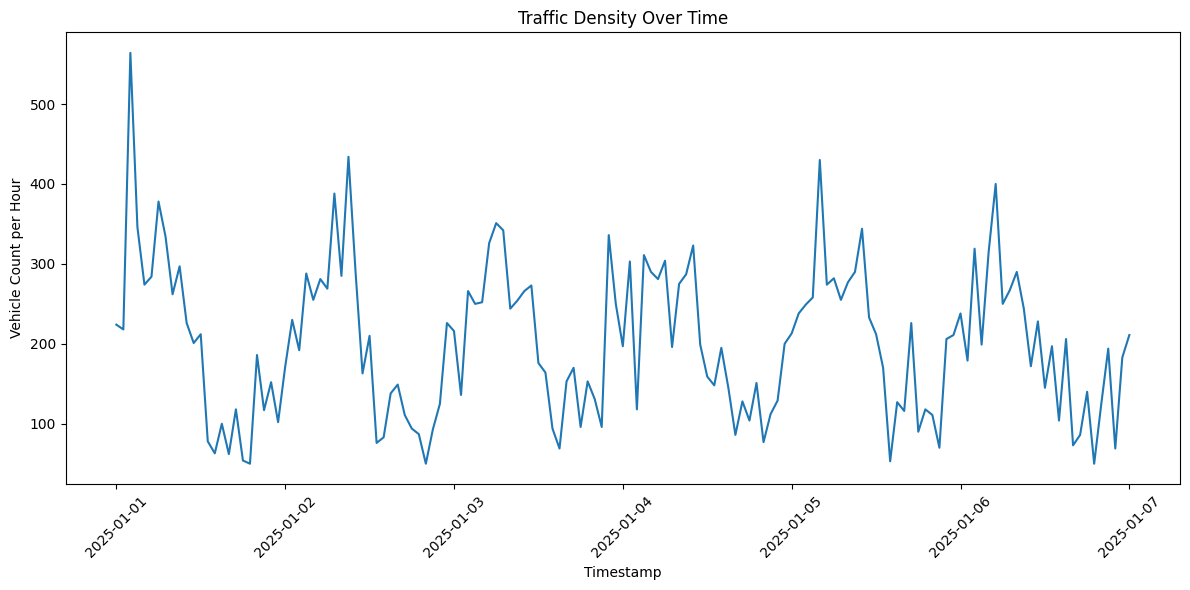

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='timestamp', y='vehicle_count', data=df)
plt.title('Traffic Density Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Vehicle Count per Hour')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

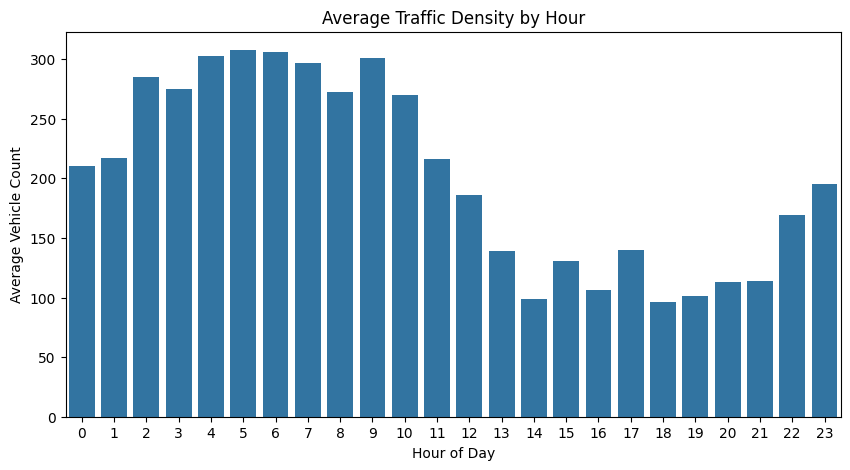

In [6]:
hourly_avg = df.groupby('hour')['vehicle_count'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='hour', y='vehicle_count', data=hourly_avg)
plt.title('Average Traffic Density by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Vehicle Count')
plt.show()

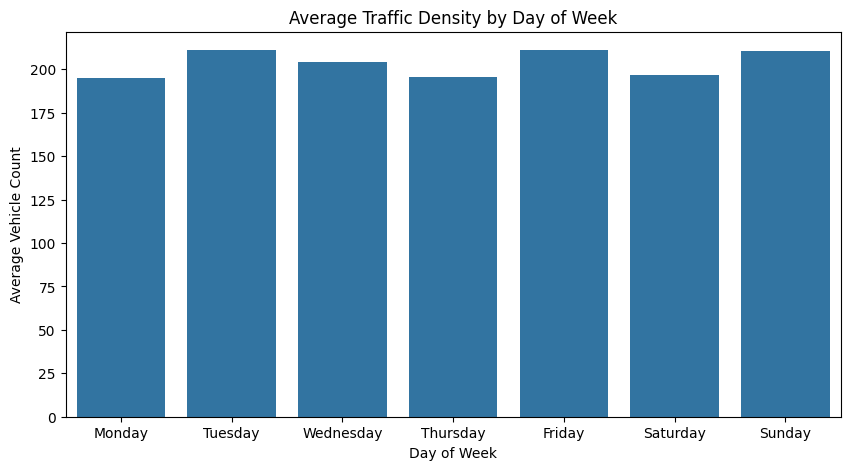

In [7]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = df.groupby('day_of_week')['vehicle_count'].mean().reindex(day_order).reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='day_of_week', y='vehicle_count', data=daily_avg)
plt.title('Average Traffic Density by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Vehicle Count')
plt.show()

In [8]:
mean_count = df['vehicle_count'].mean()
std_count = df['vehicle_count'].std()
threshold = mean_count + 2 * std_count
anomalies = df[df['vehicle_count'] > threshold][['timestamp', 'vehicle_count']]
anomalies.to_csv('traffic_anomalies.csv', index=False)

X = df[['hour']].values
y = df['vehicle_count'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
df['predicted_count'] = y_pred
mse = mean_squared_error(y, y_pred)

hours = np.arange(24).reshape(-1, 1)
predicted_counts = model.predict(hours)
peak_hour = hours[np.argmax(predicted_counts)][0]

In [10]:
report = f"""
Traffic Pattern Analysis Report
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Dataset: Synthetic vehicle count data (7 days, hourly)

1. Summary Statistics:
- Mean vehicle count: {mean_count:.2f} vehicles/hour
- Standard deviation: {std_count:.2f} vehicles/hour
- Maximum observed: {df['vehicle_count'].max()} vehicles/hour
- Minimum observed: {df['vehicle_count'].min()} vehicles/hour

2. Peak Traffic Periods:
- Predicted peak hour: {peak_hour}:00
- Highest observed traffic: {df.loc[df['vehicle_count'].idxmax(), 'timestamp']}
- Average peak hours (top 3): {hourly_avg.nlargest(3, 'vehicle_count')['hour'].values.tolist()}

3. Anomaly Detection:
- Number of anomalies detected: {len(anomalies)}
- Anomaly threshold: >{threshold:.2f} vehicles/hour
- Notable anomalies:
{anomalies.to_string(index=False)}

4. Regression Model:
- Mean Squared Error: {mse:.2f}
- Model suggests {f'higher traffic in {"morning" if peak_hour < 12 else "evening"} hours'}

5. Recommendations:
- Focus traffic management on hours {hourly_avg.nlargest(3, 'vehicle_count')['hour'].values.tolist()}
- Investigate anomalies at listed timestamps for potential incidents
- Consider alternative routes during {peak_hour}:00-{peak_hour+2}:00

Anomaly data saved: traffic_anomalies.csv
"""
with open('traffic_report.txt', 'w') as f:
    f.write(report)

print(report)


Traffic Pattern Analysis Report
Generated on: 2025-07-08 12:50:36
Dataset: Synthetic vehicle count data (7 days, hourly)

1. Summary Statistics:
- Mean vehicle count: 202.13 vehicles/hour
- Standard deviation: 94.64 vehicles/hour
- Maximum observed: 564 vehicles/hour
- Minimum observed: 50 vehicles/hour

2. Peak Traffic Periods:
- Predicted peak hour: 0:00
- Highest observed traffic: 2025-01-01 02:00:00
- Average peak hours (top 3): [5, 6, 4]

3. Anomaly Detection:
- Number of anomalies detected: 4
- Anomaly threshold: >391.41 vehicles/hour
- Notable anomalies:
          timestamp  vehicle_count
2025-01-01 02:00:00            564
2025-01-02 09:00:00            434
2025-01-05 04:00:00            430
2025-01-06 05:00:00            400

4. Regression Model:
- Mean Squared Error: 5671.73
- Model suggests higher traffic in morning hours

5. Recommendations:
- Focus traffic management on hours [5, 6, 4]
- Investigate anomalies at listed timestamps for potential incidents
- Consider alternat